# CIFAR10-SKLEARN-NN

The following script executes a program for picture recognition on the CIFAR-10 dataset using SKLearn multi-layer perceptron.

In [1]:
### Packages
from datetime import datetime
import time
import os
import matplotlib.pyplot as plt
%matplotlib inline

# Dataset
from keras.datasets import cifar10

# Subroutines
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

# Additional configurations, @see config.py
import config

# Training-Sizes
num_train = config.num_train
num_test  = config.num_test

In [2]:
# Simple functions to log information
path = os.getcwd()+"/log"
logDir = os.path.exists(path)
if not logDir:
    os.makedirs(path)

training_results = path+"/sklearn-nn-training-log.txt"
def log_training_results(*s):
    with open(training_results, 'a') as f:
        for arg in s:
            print(arg, file=f)
            print(arg)

hyperparameter_search_log = path+"/sklearn-nn-hyperparameter-tuning-log.txt"
def log_hyperparameter_search(*s):
    with open(hyperparameter_search_log, 'a') as f:
        for arg in s:
            print(arg, file=f)
            print(arg)

print("Generated data will be located in ", training_results, hyperparameter_search_log)
log_training_results("[%s] on (%s, %s) using (Train: %s, Test: %s)" % (datetime.now(), config.os, config.cpu, config.num_train, config.num_test))
if config.hyper_parameter_search:
    log_hyperparameter_search("[%s] on (%s, %s) using (Train: %s, Test: %s)" % (datetime.now(), config.os, config.cpu, config.num_train, config.num_test))



Generated data will be located in  c:\Users\auerth\Desktop\Study\CIFAR10_Benchmark\src/log/sklearn-nn-training-log.txt c:\Users\auerth\Desktop\Study\CIFAR10_Benchmark\src/log/sklearn-nn-hyperparameter-tuning-log.txt
[2022-09-22 14:49:46.111477] on (Windows-10-10.0.19044-SP0, Intel64 Family 6 Model 140 Stepping 1, GenuineIntel) using (Train: 12500, Test: 2500)
[2022-09-22 14:49:46.122367] on (Windows-10-10.0.19044-SP0, Intel64 Family 6 Model 140 Stepping 1, GenuineIntel) using (Train: 12500, Test: 2500)


In [3]:
# Fetch CIFAR10-Data from Keras repository
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [4]:
print("\t\t\t\t (Sets,  X,  Y, RGB)")
print("Shape of training data:\t\t", X_train.shape)
print("Shape of training labels:\t", y_train.shape)
print("Shape of testing data:\t\t", X_test.shape)
print("Shape of testing labels:\t", y_test.shape)

				 (Sets,  X,  Y, RGB)
Shape of training data:		 (50000, 32, 32, 3)
Shape of training labels:	 (50000, 1)
Shape of testing data:		 (10000, 32, 32, 3)
Shape of testing labels:	 (10000, 1)


C:\Users\auerth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\matplotlib\text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


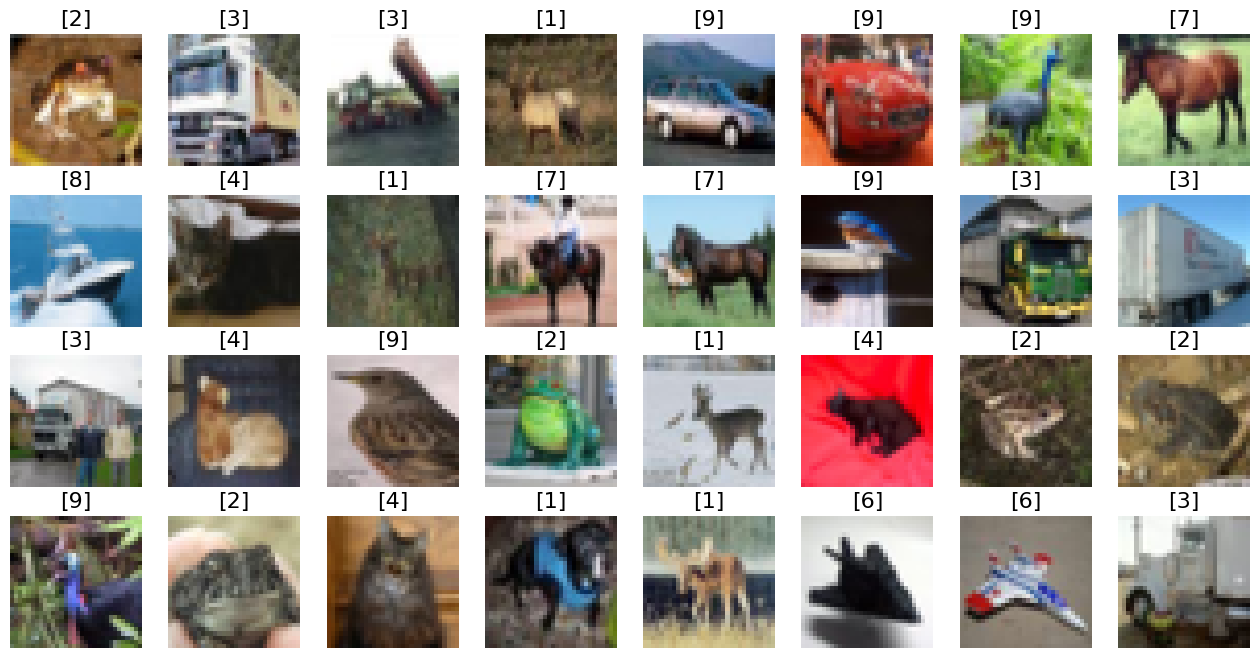

In [5]:
# Visualize some examples
cols=8
rows=4
fig, ax = plt.subplots(ncols=cols, nrows=rows, figsize=(cols*2, rows*2))
index = 0
for i in range(rows):
    for j in range(cols):
        ax[i,j].imshow(X_train[index])
        ax[i,j].set_title(y_train[y_train[index][0]], fontsize=16)
        ax[i,j].imshow(X_train[index])
        ax[i,j].axis('off')
        index += 1
plt.show()


In [6]:
train_data = X_train
train_label = y_train
test_data = X_test
test_label = y_test

In [7]:
# Reshape the data such that we have access to every pixel of the image
# The reason to access every pixel is that only then we can apply deep learning ideas and can assign color code to every pixel.
# https://datascience.stackexchange.com/questions/24459/how-to-give-cifar-10-as-an-input-to-mlp
train_data = X_train.reshape(X_train.shape[0], 32*32*3).astype('float32')
train_label = y_train.astype("float32")
test_data = X_test.reshape(X_test.shape[0], 32*32*3).astype('float32')
test_label = y_test.astype("float32")


In [8]:
# We know the RGB color code where different values produce various colors. It is also difficult to remember every color combination. 
# We already know that each pixel has its unique color code and also we know that it has a maximum value of 255. 
# To perform Machine Learning, it is important to convert all the values from 0 to 255 for every pixel to a range of values from 0 to 1.
train_data = train_data / 255
test_data = test_data / 255

In [9]:
# As an optional step, we decrease the training and testing data size, such that the algorithms perform their execution in acceptable time
train_data = train_data[1:num_train]
train_label = train_label[1:num_train]

test_data = test_data[1:num_test]
test_label = test_label[1:num_test]

In [10]:
print("\t\t\t\t (Sets,  X*Y*RGB)")
print("Reshaped training data:\t\t", train_data.shape)
print("Reshaped training labels:\t", train_label.shape)
print("Reshaped testing data:\t\t", test_data.shape)
print("Reshaped testing labels:\t", test_label.shape)

				 (Sets,  X*Y*RGB)
Reshaped training data:		 (12499, 3072)
Reshaped training labels:	 (12499, 1)
Reshaped testing data:		 (2499, 3072)
Reshaped testing labels:	 (2499, 1)


## Multi-layer Perceptron classifier

This model optimizes the log-loss function using LBFGS or stochastic gradient descent.

For more information, see: https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html

In [11]:
# @see https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html
mlp = MLPClassifier(
    hidden_layer_sizes=(100,),      # The ith element represents the number of neurons in the ith hidden layer.
    activation='relu',              # Activation function for the hidden layer.
    solver='adam',                  # The solver for weight optimization.
    alpha=0.0001,                   # Strength of the L2 regularization term. The L2 regularization term is divided by the sample size when added to the loss.
    batch_size='auto',              # Size of minibatches for stochastic optimizers. If the solver is ‘lbfgs’, the classifier will not use minibatch. When set to “auto”, batch_size=min(200, n_samples).
    learning_rate='constant',       # Learning rate schedule for weight updates.
    learning_rate_init=0.001,       # The initial learning rate used. It controls the step-size in updating the weights. Only used when solver=’sgd’ or ‘adam’.
    power_t=0.5,                    # The exponent for inverse scaling learning rate. It is used in updating effective learning rate when the learning_rate is set to ‘invscaling’. Only used when solver=’sgd’.
    max_iter=200,                   # Maximum number of iterations. The solver iterates until convergence (determined by ‘tol’) or this number of iterations.
    shuffle=True,                   # Whether to shuffle samples in each iteration. Only used when solver=’sgd’ or ‘adam’.
    random_state=None,              # Determines random number generation for weights and bias initialization, train-test split if early stopping is used, and batch sampling when solver=’sgd’ or ‘adam’.
    tol=0.0001,                     # Tolerance for the optimization. When the loss or score is not improving by at least tol for n_iter_no_change consecutive iterations, unless learning_rate is set to ‘adaptive’, convergence is considered to be reached and training stops.
    verbose=False,                  # Whether to print progress messages to stdout.
    warm_start=False,               # When set to True, reuse the solution of the previous call to fit as initialization, otherwise, just erase the previous solution.
    momentum=0.9,                   # Momentum for gradient descent update. Should be between 0 and 1. Only used when solver=’sgd’.
    nesterovs_momentum=True,        # Whether to use Nesterov’s momentum. Only used when solver=’sgd’ and momentum > 0.
    early_stopping=False,           # Whether to use early stopping to terminate training when validation score is not improving. 
    validation_fraction=0.1,        # The proportion of training data to set aside as validation set for early stopping. Only used if early_stopping is True.
    beta_1=0.9,                     # Exponential decay rate for estimates of first moment vector in adam, should be in [0, 1). Only used when solver=’adam’.
    beta_2=0.999,                   # Exponential decay rate for estimates of second moment vector in adam, should be in [0, 1). Only used when solver=’adam’.
    epsilon=1e-08,                  # Value for numerical stability in adam. Only used when solver=’adam’.
    n_iter_no_change=10,            # Maximum number of epochs to not meet tol improvement. Only effective when solver=’sgd’ or ‘adam’.
    max_fun=15000                   # Only used when solver=’lbfgs’. Maximum number of loss function calls. 
)

In [12]:
# Set up the multi-layer perceptron classifier and fit to datasets.
mlp = MLPClassifier(
    batch_size=config.batch_size,
    max_iter=config.num_epochs,
    hidden_layer_sizes=config.num_of_units
)

start_time = time.time()
#   train_data ... ndarray or sparse matrix of shape (n_samples, n_features), the input data
#   train_label ... ndarray of shape (n_samples,) or (n_samples, n_outputs), the target values (class labels in classification, real numbers in regression)
mlp.fit(train_data, train_label)
end_time = time.time() - start_time

params = {"MLP":{'batch_size':mlp.get_params()["batch_size"], 'num_epochs':mlp.get_params()["max_iter"], 'num_of_units':mlp.get_params()["hidden_layer_sizes"], 'activation':mlp.get_params()["activation"], 'alpha':mlp.get_params()["alpha"], 'epsilon':mlp.get_params()["epsilon"]}}
log_training_results("Trained new model: %s in %s seconds" % (params, end_time))

C:\Users\auerth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1118: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Trained new model: {'MLP': {'batch_size': 32, 'num_epochs': 20, 'num_of_units': 256, 'activation': 'relu', 'alpha': 0.0001, 'epsilon': 1e-08}} in 350.7243616580963 seconds


C:\Users\auerth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


In [13]:
# Predict using the multi-layer perceptron classifier.
start_time = time.time()
#   train_data ... {array-like, sparse matrix} of shape (n_samples, n_features)
predictions = mlp.predict(train_data)
end_time = time.time() - start_time
log_training_results("\tPredicting train data -- execution time: %ss" % (end_time))


start_time = time.time()
predictions = mlp.predict(test_data)
end_time = time.time() - start_time
log_training_results("\tPredicting test data -- execution time: %ss" % (end_time))


	Predicting train data -- execution time: 0.9446327686309814s
	Predicting test data -- execution time: 0.1819934844970703s


In [14]:
# Analyze results
start_time = time.time()
score = mlp.score(train_data, train_label)
end_time = time.time() - start_time
log_training_results("\t[Train-data x %s] -- mean accuracy: %s; execution time: %ss" % (params, score, end_time))  

start_time = time.time()
score = mlp.score(test_data, test_label)
end_time = time.time() - start_time
log_training_results("\t[Test-data x %s] -- mean accuracy: %s; execution time: %ss" % (params, score, end_time))  

	[Train-data x {'MLP': {'batch_size': 32, 'num_epochs': 20, 'num_of_units': 256, 'activation': 'relu', 'alpha': 0.0001, 'epsilon': 1e-08}}] -- mean accuracy: 0.4793183454676374; execution time: 1.0389904975891113s
	[Test-data x {'MLP': {'batch_size': 32, 'num_epochs': 20, 'num_of_units': 256, 'activation': 'relu', 'alpha': 0.0001, 'epsilon': 1e-08}}] -- mean accuracy: 0.41936774709883956; execution time: 0.23080992698669434s


## Hyperparameter evaluation

Search of optimal parameters using GridSearchCV and predefined values.

For more information, see https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In [15]:
# # # Hyperparameter search -- Takes up a long time.
# 960 Fits for all params, takes 2 days lol
# 240 Fits for reduced params, takes roughly 8 hours
# From previous assignment, we know that relu and adam did best
if config.hyper_parameter_search:
    mlp = MLPClassifier()
    parameters = {
        'hidden_layer_sizes': [(64,),(128,),(256,),(512,)],
        'max_iter': [10, 20],
        'batch_size': [64, 128, 256],
        'activation': ['tanh', 'relu'],
        #'activation': ['relu'],
        'solver': ['sgd', 'adam'],
        #'solver': ['adam'],
        'alpha': [0.001, 0.0001],
        'learning_rate': ['constant','adaptive'],
    }

    log_hyperparameter_search("--- [%s] Running Parameter-Tests [SKLEARN-NN] ---" % datetime.now())
    grid = GridSearchCV(estimator=mlp, param_grid=parameters, verbose=3, n_jobs=-1)
    grid.fit(train_data, train_label)

    log_hyperparameter_search("\tBest parameters set found on following development set:")
    log_hyperparameter_search("\t\tSupport Vector: %s" % grid.best_estimator_)
    log_hyperparameter_search("\t\tSupport Vector Parametrization: %s" % grid.best_params_)
    log_hyperparameter_search("\t\tAsserted Score: %s" % grid.best_score_)
    log_hyperparameter_search("Total Score \t\t Configurations")

    means = grid.cv_results_["mean_test_score"]
    stds = grid.cv_results_["std_test_score"]
    params = grid.cv_results_["params"]
    for mean, std, params in zip(means, stds, params):
        log_hyperparameter_search("%0.3f (+/-%0.03f)\t%r" % (mean, std, params))
    print("Wrote classifier comparisons to file ", hyperparameter_search_log)

    print("Detailed classification report:")
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    
    y_true, y_pred = test_label, grid.predict(test_data)
    log_hyperparameter_search(classification_report(y_true, y_pred))
    print()

--- [2022-09-22 14:55:44.246048] Running Parameter-Tests [SKLEARN-NN] ---
Fitting 5 folds for each of 384 candidates, totalling 1920 fits


C:\Users\auerth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1118: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\auerth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


	Best parameters set found on following development set:
		Support Vector: MLPClassifier(alpha=0.001, batch_size=64, hidden_layer_sizes=(512,),
              max_iter=20, solver='sgd')
		Support Vector Parametrization: {'activation': 'relu', 'alpha': 0.001, 'batch_size': 64, 'hidden_layer_sizes': (512,), 'learning_rate': 'constant', 'max_iter': 20, 'solver': 'sgd'}
		Asserted Score: 0.438674893957583
Total Score 		 Configurations
0.385 (+/-0.007)	{'activation': 'tanh', 'alpha': 0.001, 'batch_size': 64, 'hidden_layer_sizes': (64,), 'learning_rate': 'constant', 'max_iter': 10, 'solver': 'sgd'}
0.363 (+/-0.009)	{'activation': 'tanh', 'alpha': 0.001, 'batch_size': 64, 'hidden_layer_sizes': (64,), 'learning_rate': 'constant', 'max_iter': 10, 'solver': 'adam'}
0.404 (+/-0.007)	{'activation': 'tanh', 'alpha': 0.001, 'batch_size': 64, 'hidden_layer_sizes': (64,), 'learning_rate': 'constant', 'max_iter': 20, 'solver': 'sgd'}
0.383 (+/-0.009)	{'activation': 'tanh', 'alpha': 0.001, 'batch_size': 